In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# Helper libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# From the tutorial
# https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
#from sklearn.model_selection import KFold

from datetime import datetime
from packaging import version

2022-05-02 00:12:19.559024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 00:12:19.559046: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Parameters 
epochs_1 = 30
epochs_2 = 15
k = 10000
learning_rate = 0.001
probability_new_data = 0.5
num_data = 10000

In [3]:
def plotter(images_to_plot,name_of_png):
    # images_to_plot list
    # name_output string "KASAM_Experiment_A/Experiment_A_Inspection_SAM.png"
    num_rows = 1
    num_cols = 1
    interpol = 'none' # 'nearest'
    xticks = [0,0.5,1] #[0,0.25,0.5,0.75,1]
    yticks = [0,0.5,1]
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][2] # 'inferno'
    subplot_titles = ['1st Target','1st Output','2nd Target','2nd Output','Difference'] #['a','b','c','d','e']

    fig, axs = plt.subplots(1, 5, sharex='col', sharey='row',figsize=(20,4))
    #fig.tight_layout()

    for col in range(5):    
        ax = axs[col]
        ax.set_title(subplot_titles[col],fontsize=20)
        ax.set_aspect(1)
        ax.set_xlabel(r'$x_{1}$',fontsize=17)
        ax.set_xticks(xticks)
        ax.tick_params(axis='x', which='major', labelsize=12)

        if col==0:
            ax.set_ylabel(r'$x_{2}$',fontsize=17)
            ax.set_yticks(yticks)
            ax.tick_params(axis='y', which='major', labelsize=12)
        pcm = ax.imshow(images_to_plot[col], cmap=cmaps, interpolation='none', extent=[0.,1,0.,1.],origin='lower')
        #pcm.set_clim(np.min(images_to_plot),np.max(images_to_plot))
        pcm.set_clim(-2.5,2.5)

    #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2], pad=0.02, aspect=10)
    cb = fig.colorbar(pcm, ax=axs, shrink=0.7, pad=0.02, aspect=10)
    #cb.set_label(r'$y(x_{1}, x_{2})$', labelpad=10, size=20)
    cb.set_label(r'Function Value', labelpad=15, size=18)
    cb.ax.tick_params(labelsize=14)

    fig.savefig(name_of_png, 
                close = True, verbose = True, dpi=500,bbox_inches='tight')

Model: "kasam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 OSAM_P0 (Dense)             multiple                  360       
                                                                 
 OSAM_F0 (Dense)             multiple                  120       
                                                                 
 Inner_Functions (Dense)     multiple                  360       
                                                                 
 Projected_Inner_Res (Dense)  multiple                 3         
                                                                 
 Sigmoid (Activation)        multiple                  0         
                                                                 
 Outer_OSAM_P0 (Dense)       multiple                  720       
                                                                 
 Outer_OSAM_F0 (Dense)       multiple                  180   

2022-05-02 00:12:21.363419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 00:12:21.363460: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 00:12:21.363475: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Heinrich-XD): /proc/driver/nvidia/version does not exist
2022-05-02 00:12:21.363646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/heinrich/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argu

313/313 [==============================] - 0s 1ms/step - loss: 0.0157 - mse: 0.0157


/tmp/ipykernel_11477/134588316.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "close" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(name_of_png,
/tmp/ipykernel_11477/134588316.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "verbose" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(name_of_png,


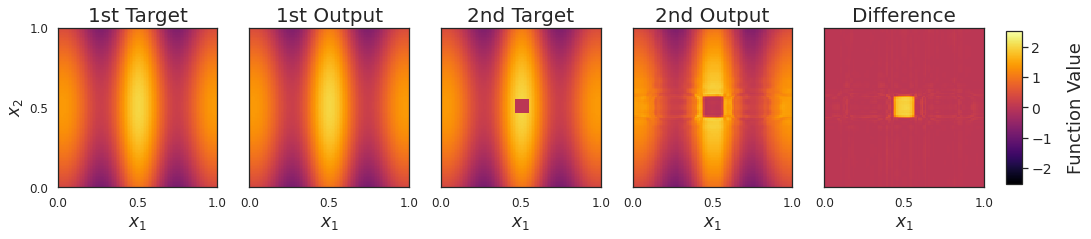

In [4]:
def s(x):
    
    "Activation function to implement the basis functions"
    
    y0 = K.switch(tf.logical_and(tf.zeros(tf.shape(x))<=x, x<tf.ones(tf.shape(x))), 
                 x**3/6, 
                 tf.zeros(tf.shape(x))
                )
    
    y1 = K.switch(tf.logical_and(tf.ones(tf.shape(x))<=x, x<2*tf.ones(tf.shape(x))),
                 (-3.*(x-1.)**3 +3.*(x-1.)**2 + 3*(x-1.)+1.)/6.,
                 tf.zeros(tf.shape(x))
                )
    
    y2 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*2<=x, x<3*tf.ones(tf.shape(x))),
                 (3*(x-2)**3 - 6*(x-2)**2 + 4. )/6.,
                 tf.zeros(tf.shape(x))
                )

    y3 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*3<=x, x<4*tf.ones(tf.shape(x))),
                 ( 4. -x)**3/6.,
                 tf.zeros(tf.shape(x))
                )    
    
    y  = y0 + y1 + y2 + y3
    
    return y

def partition_weights(n,n0):
    p0 = n0*n
    y = np.zeros((n,p0))
    for i in range(n):
        y[i,i*n0:(i+1)*n0] = 1.
    return y 

def partition_bias(n,n0):
    p0 = n0*n
    return (np.arange(0.,p0)%n0)    

"""def f(x,y):
    #v0 = np.cos(4.*np.pi*x)*np.exp(-4*(x-0.5)**2) + np.sin(1.*np.pi*y)
    xt = 20.*x - 10.
    yt = 20.*y - 10.
    
    v0 = 1 + np.sin(xt)**2+np.sin(yt)**2 + 2.*np.exp(-xt**2-yt**2)
    return v0

def f2(x,y):
    
    l0 = np.ones(x.shape)
    l1 = np.logical_and((x < 0.55*l0),(0.45*l0 < x ))
    l2 = np.logical_and((y < 0.55*l0),(0.45*l0 < y ))
    l3 = np.logical_and(l1,l2)
    
    v0 = f(x,y)*np.logical_not(l3) + 0.*l3
    
    return v0"""

def f(x):
    #xt = 20.*x - 10.
    #v0 = 1 + np.sin(xt[0])**2+np.sin(xt[1])**2 + 2.*np.exp(-xt[0]**2-xt[1]**2)
    
    v0 = np.cos(4.*np.pi*x[0])*np.exp(-4*(x[0]-0.5)**2) + np.sin(1.*np.pi*x[1])
    #v0 = 1*x[0] + 2.*np.pi*x[1]
    return v0

def f2(x):
    
    l0 = np.ones(x[0,:].shape)
    l1 = np.logical_and((x[0] < 0.55*l0),(0.45*l0 < x[0] ))
    l2 = np.logical_and((x[1] < 0.55*l0),(0.45*l0 < x[1] ))
    l3 = np.logical_and(l1,l2)
    
    v0 = f(x)*np.logical_not(l3) + 0.*l3
    
    return v0

##################################################################################################

resolution = 0.01

x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)

array_grid = np.array(np.meshgrid(x0, x1))
y0 = f(array_grid)

x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)

x0, x1 = np.meshgrid(x0, x1)

coordinates = np.array([x0.flatten(),x1.flatten()]).transpose()
##################################################################################################


# Data Generation 
# randomly and uniformly sampled 


rs = np.random.RandomState(16989)

#train_inputs = np.random.rand(10000,2)
train_inputs = rs.rand(k,2)

train_output = np.array([f(train_inputs.T)]).T

# Test on First task
##################################################################################
x_test1 = np.random.rand(k,2)
y_test1 = np.array([f(x_test1.T)]).T

#results1 = model.evaluate(x_test1, y_test1)


# Task 2 
rs2 = np.random.RandomState(13989)

train_inputs_2 = 0.11*rs2.rand(k,2)+0.44
#train_inputs_2 = 0.11*np.random.rand(k,2)+0.44

train_output_2 = np.ones(k)*0.

# Test on Second task
##################################################################################
x_test2 = np.random.rand(k,2)
y_test2 = np.array([f2(x_test2.T)]).T

#results1 = model.evaluate(x_test1, y_test1)
##################################################################################################

def spline_function_(n,m,c0,u0):
    """
    Function from [0,1]^n to R^m
    n  - Input dimension
    m  - output dimension
    c0 - the capacity of the network, the number of control points for each input variable is proportional capacity
    u0 - the initial value of all control points
    """
    
    d0 = 3 
 
    n0 = c0 + d0 # the number of control points; capacity + degree of basis function
    p0 = n0*n

    w0 = tf.constant_initializer(c0*partition_weights(n,n0))
    b0 = tf.constant_initializer(d0 - partition_bias(n,n0))
    
    w1 = tf.constant_initializer(0.)

    inn = tf.keras.layers.Input(shape=(n,))

    l00 = tf.keras.layers.Dense(activation=s,
                                units=p0,
                                use_bias=True,
                                trainable=False,
                                kernel_initializer=w0,
                                bias_initializer=b0 
                               )(inn)          # Modified
    
    out = tf.keras.layers.Dense(units=m,
                                use_bias=False,
                                trainable=True,
                                kernel_initializer=w1
                               )(l00)

    model = tf.keras.Model(inputs=inn, 
                           outputs= out
                          )
    return model

class Memory_Regularizer(tf.keras.regularizers.Regularizer):
    
    def __init__(self, h0=0.,weight_memory = 0.):
        self.h0 = h0
        self.weight_memory = weight_memory
        
    def __call__(self, x):
        #self.l2 * tf.math.reduce_sum(tf.math.square(x))
        #self.h0 * tf.math.reduce_sum(tf.math.abs(x-self.weight_memory))
        return self.h0 * tf.math.reduce_sum(tf.math.square(x-self.weight_memory))
    
    def get_config(self):
        
        return {'h0': float(self.h0)}
    
def partition_weights_2(n,r):
    d0 = float(3)
    l0 = 4*(2**np.arange(0,r))
    l1 = [(x-d0)*partition_weights(n,x) for x in l0]
    l2 = np.concatenate(l1,axis=1)
    return l2

def partition_bias_2(n,r):
    d0 = float(3)
    l0 = 4*(2**np.arange(0,r))
    l1 = [d0 - partition_bias(n,x) for x in l0]
    l2 = np.concatenate(l1,axis=0)
    return l2

class kasam(keras.Model):
    """ """
    def __init__(self, n, m, r, k, h):
        super(kasam, self).__init__()
        
        #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        #tf.constant_initializer(0.)
        
        self.n = n
        self.m = m
        self.r = r
        self.k = k
        #self.h = h
        
        self.memory_regulizer_f11 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f02 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f55 = Memory_Regularizer(h0=h,weight_memory=0.)
        
        
        self.f01 = tf.keras.layers.Dense(activation=s,
                                     name='OSAM_P0',
                                     units=n*((4*(2**np.arange(0,r))).sum()),
                                     use_bias=True,
                                     trainable=False,
                                     kernel_initializer=tf.constant_initializer(partition_weights_2(n,r)),
                                     bias_initializer=tf.constant_initializer(partition_bias_2(n,r)))
        
        self.f11 = tf.keras.layers.Dense(units=m,
                                     name='OSAM_F0',
                                     use_bias=False,
                                     trainable=True,
                                     kernel_initializer=tf.constant_initializer(0.),
                                     kernel_regularizer=self.memory_regulizer_f11)
        
        self.f02 = tf.keras.layers.Dense(activation=None,
                                         name='Inner_Functions',
                                         units=k,
                                         use_bias=False,
                                         trainable=True,
                                         kernel_initializer=tf.random_normal_initializer(mean=0.0,
                                                                                         stddev=0.05,
                                                                                         seed=7),
                                         kernel_regularizer= self.memory_regulizer_f02)
        
        self.f22 = tf.keras.layers.Dense(activation=None,
                                         name='Projected_Inner_Res',
                                         units=m,
                                         use_bias=False,
                                         trainable=False,
                                         kernel_initializer=tf.constant_initializer(1./k/n)
                                        )
        
        self.f03 = tf.keras.layers.Activation(tf.nn.sigmoid,name='Sigmoid')
        
        self.f04 = tf.keras.layers.Dense(activation=s,
                                         name='Outer_OSAM_P0',
                                         units=k*((4*(2**np.arange(0,r))).sum()),
                                         use_bias=True,
                                         trainable=False,
                                         kernel_initializer=tf.constant_initializer(partition_weights_2(k,r)),
                                         bias_initializer=tf.constant_initializer(partition_bias_2(k,r)))
        
        
        self.f55 = tf.keras.layers.Dense(units=m,
                                         name='Outer_OSAM_F0',
                                         use_bias=False,
                                         trainable=True,
                                         kernel_initializer=tf.constant_initializer(0.),
                                         kernel_regularizer= self.memory_regulizer_f55)
        
        self.out = tf.keras.layers.Add(name='Model_Output')
        
    def call(self, input_tensor, training=False):
        
        f01 = self.f01(input_tensor)
        f11 = self.f11(f01)
        
        f02 = self.f02(f01)
        f22 = self.f22(f02)
        
        f03 = self.f03(f02)
        f04 = self.f04(f03)
        f55 = self.f55(f04)
        
        out = self.out([f11,f22,f55])
        return out
                
    def construct(self):
        """
        Use explicit construct method so that summary method displays the correct output shape of each layer
        Otherwise it just says multiple which is useless information 
        """
        self(tf.keras.layers.Input(shape=(self.n,)))
        
    def memory_update(self):
        
        self.memory_regulizer_f11.weight_memory = tf.constant(self.f11.get_weights())
        self.memory_regulizer_f02.weight_memory = tf.constant(self.f02.get_weights())
        self.memory_regulizer_f55.weight_memory = tf.constant(self.f55.get_weights())
        
class typical_ann(keras.Model):
    """ """
    def __init__(self, n, m, r, k, h):
        super(typical_ann, self).__init__()
        
        #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        #tf.constant_initializer(0.)
        
        self.n = n
        self.m = m
        self.r = r
        self.k = k
        #self.h = h
        
        self.memory_regulizer_f11 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f02 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f55 = Memory_Regularizer(h0=h,weight_memory=0.)
        
        
        self.f01 = tf.keras.layers.Dense(activation=s,
                                     name='OSAM_P0',
                                     units=n*((4*(2**np.arange(0,r))).sum()),
                                     use_bias=True,
                                     trainable=True)
        
        self.f11 = tf.keras.layers.Dense(units=m,
                                     name='OSAM_F0',
                                     use_bias=False,
                                     trainable=True)
        
        self.f02 = tf.keras.layers.Dense(activation=None,
                                         name='Inner_Functions',
                                         units=k,
                                         use_bias=False,
                                         trainable=True)
        
        self.f22 = tf.keras.layers.Dense(activation=None,
                                         name='Projected_Inner_Res',
                                         units=m,
                                         use_bias=False,
                                         trainable=True)
        
        self.f03 = tf.keras.layers.Activation(tf.nn.sigmoid,name='Sigmoid')
        
        self.f04 = tf.keras.layers.Dense(activation=s,
                                         name='Outer_OSAM_P0',
                                         units=k*((4*(2**np.arange(0,r))).sum()),
                                         use_bias=True,
                                         trainable=True)
        
        
        self.f55 = tf.keras.layers.Dense(units=m,
                                         name='Outer_OSAM_F0',
                                         use_bias=False,
                                         trainable=True)
        
        self.out = tf.keras.layers.Add(name='Model_Output')
        
    def call(self, input_tensor, training=False):
        
        f01 = self.f01(input_tensor)
        f11 = self.f11(f01)
        
        f02 = self.f02(f01)
        f22 = self.f22(f02)
        
        f03 = self.f03(f02)
        f04 = self.f04(f03)
        f55 = self.f55(f04)
        
        out = self.out([f11,f22,f55])
        return out
                
    def construct(self):
        """
        Use explicit construct method so that summary method displays the correct output shape of each layer
        Otherwise it just says multiple which is useless information 
        """
        self(tf.keras.layers.Input(shape=(self.n,)))
        
    def memory_update(self):
        
        self.memory_regulizer_f11.weight_memory = tf.constant(self.f11.get_weights())
        self.memory_regulizer_f02.weight_memory = tf.constant(self.f02.get_weights())
        self.memory_regulizer_f55.weight_memory = tf.constant(self.f55.get_weights())
        
def SAM_evaluation():
    #
    ##################################################################################################

    # Initialise a model
    # n,m,r,k,u0,h0
    n   = 2
    m   = 1
    c0  = 61
    u0  = 0.

    model = spline_function_(n,m,c0,u0)


    # Print model summary
    model.summary()

    ##################################################################################################
    output1 = model.predict(coordinates).reshape(100,100)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

    initial_mse_1 = model.evaluate(train_inputs, train_output)

    history_1 = model.fit(train_inputs, train_output, epochs=epochs_1,verbose=0)

    train_loss_values_1 = [initial_mse_1[-1]]+history_1.history['mse']

    output2 = model.predict(coordinates).reshape(100,100)

    results1 = model.evaluate(x_test1, y_test1)[-1]
    ##################################################################################################
    y_new = f2(array_grid)

    initial_mse_2 = model.evaluate(train_inputs_2, train_output_2)

    history_2 = model.fit(train_inputs_2, train_output_2, epochs=epochs_2,verbose=0)

    train_loss_values_2 = [initial_mse_2[-1]]+history_2.history['mse']

    output3 = model.predict(coordinates).reshape(100,100)

    results2 = model.evaluate(x_test2, y_test2)[-1]
    ##################################################################################################

    images_to_plot = [y0,output2,y_new,output3,np.abs(output3-output2)]

    ##################################################################################################
    plotter(images_to_plot,"KASAM_Experiment_A/Inspection_SAM.png")
    ##################################################################################################
    
    return (train_loss_values_1,train_loss_values_2,results1,results2)

def KASAM_evaluation():
    #
    ##################################################################################################

    # Initialise a model
    # n,m,r,k,u0,h0
    n   = 2
    m   = 1
    r   = 4
    k   = 3
    h   = 0.

    model = kasam(n,m,r,k,h)

    model.construct()


    # Print model summary
    model.summary()

    ##################################################################################################
    output1 = model.predict(coordinates).reshape(100,100)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

    initial_mse_1 = model.evaluate(train_inputs, train_output)

    history_1 = model.fit(train_inputs, train_output, epochs=epochs_1,verbose=0)

    train_loss_values_1 = [initial_mse_1[-1]]+history_1.history['mse']

    output2 = model.predict(coordinates).reshape(100,100)

    results1 = model.evaluate(x_test1, y_test1)[-1]
    
    model.memory_update()
    ##################################################################################################
    y_new = f2(array_grid)

    initial_mse_2 = model.evaluate(train_inputs_2, train_output_2)

    history_2 = model.fit(train_inputs_2, train_output_2, epochs=epochs_2,verbose=0)

    train_loss_values_2 = [initial_mse_2[-1]]+history_2.history['mse']

    output3 = model.predict(coordinates).reshape(100,100)

    results2 = model.evaluate(x_test2, y_test2)[-1]
    ##################################################################################################

    images_to_plot = [y0,output2,y_new,output3,np.abs(output3-output2)]

    ##################################################################################################
    plotter(images_to_plot,"KASAM_Experiment_A/Inspection_KASAM.png")
    ##################################################################################################
    
    return (train_loss_values_1,train_loss_values_2,results1,results2)

def Typical_ANN_evaluation():
    #
    ##################################################################################################
    # Initialise a model
    # n,m,r,k,u0,h0
    n   = 2
    m   = 1
    r   = 4
    k   = 3
    h   = 0.

    model = typical_ann(n,m,r,k,h)

    model.construct()


    # Print model summary
    model.summary()

    ##################################################################################################
    output1 = model.predict(coordinates).reshape(100,100)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

    initial_mse_1 = model.evaluate(train_inputs, train_output)

    history_1 = model.fit(train_inputs, train_output, epochs=epochs_1,verbose=0)

    train_loss_values_1 = [initial_mse_1[-1]]+history_1.history['mse']

    output2 = model.predict(coordinates).reshape(100,100)

    results1 = model.evaluate(x_test1, y_test1)[-1]
    
    model.memory_update()
    ##################################################################################################
    y_new = f2(array_grid)

    initial_mse_2 = model.evaluate(train_inputs_2, train_output_2)

    history_2 = model.fit(train_inputs_2, train_output_2, epochs=epochs_2,verbose=0)

    train_loss_values_2 = [initial_mse_2[-1]]+history_2.history['mse']

    output3 = model.predict(coordinates).reshape(100,100)

    results2 = model.evaluate(x_test2, y_test2)[-1]
    ##################################################################################################

    images_to_plot = [y0,output2,y_new,output3,np.abs(output3-output2)]

    ##################################################################################################
    plotter(images_to_plot,"KASAM_Experiment_A/Inspection_ANN.png")
    ##################################################################################################
    
    return (train_loss_values_1,train_loss_values_2,results1,results2)

def KASAM_PR_evaluation():
    #
    ##################################################################################################

    # Initialise a model
    # n,m,r,k,u0,h0
    n   = 2
    m   = 1
    r   = 4
    k   = 3
    h   = 0.

    model = kasam(n,m,r,k,h)

    model.construct()


    # Print model summary
    model.summary()

    ##################################################################################################
    output1 = model.predict(coordinates).reshape(100,100)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

    initial_mse_1 = model.evaluate(train_inputs, train_output)

    history_1 = model.fit(train_inputs, train_output, epochs=epochs_1,verbose=0)

    train_loss_values_1 = [initial_mse_1[-1]]+history_1.history['mse']

    output2 = model.predict(coordinates).reshape(100,100)

    results1 = model.evaluate(x_test1, y_test1)[-1]
    
    model.memory_update()
    ##################################################################################################
    y_new = f2(array_grid)

    initial_mse_2 = model.evaluate(train_inputs_2, train_output_2)
    
    ################################
    # New Data

    train_inputs_new_data = train_inputs_2.copy()
    train_labels_new_data = train_output_2.copy()

    index_choice =  np.random.randint(0,len(train_labels_new_data),num_data)

    new_input_samples = train_inputs_new_data[index_choice,:]
    new_label_samples = train_labels_new_data[index_choice]

    mem_input_samples = np.random.rand(num_data,2).astype('float32')
    mem_label_samples = model.predict(mem_input_samples).reshape(num_data)

    reveries_input = np.zeros((num_data,2)).astype('float32')
    reveries_label = np.zeros(num_data).astype('float32')

    reverie_constructor = np.random.choice([True,False],
                                    num_data,
                                    p=[probability_new_data,1.-probability_new_data]
                                   )

    reveries_input[reverie_constructor] = new_input_samples[reverie_constructor]
    reveries_label[reverie_constructor] = new_label_samples[reverie_constructor]

    reveries_input[np.logical_not(reverie_constructor)] = mem_input_samples[np.logical_not(reverie_constructor)]
    reveries_label[np.logical_not(reverie_constructor)] = mem_label_samples[np.logical_not(reverie_constructor)]
    
    #############################################################################

    history_2 = model.fit(reveries_input, reveries_label, epochs=epochs_2,verbose=0)

    train_loss_values_2 = [initial_mse_2[-1]]+history_2.history['mse']

    output3 = model.predict(coordinates).reshape(100,100)

    results2 = model.evaluate(x_test2, y_test2)[-1]
    ##################################################################################################

    images_to_plot = [y0,output2,y_new,output3,np.abs(output3-output2)]

    ##################################################################################################
    plotter(images_to_plot,"KASAM_Experiment_A/Inspection_KASAM_PR.png")
    ##################################################################################################
    
    return (train_loss_values_1,train_loss_values_2,results1,results2)

#sam_eval = SAM_evaluation();
#kasam_eval = KASAM_evaluation();
#ann_eval = Typical_ANN_evaluation()
kasam_pr_eval = KASAM_PR_evaluation();

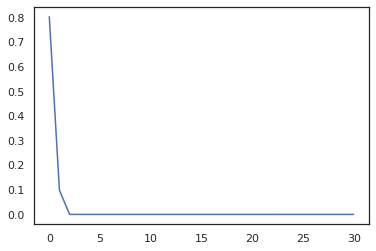

In [5]:
plt.plot(kasam_pr_eval[0])

In [6]:
kasam_pr_eval[0]

[0.8025020360946655,
 0.0983051061630249,
 8.277458255179226e-05,
 2.0964273062418215e-05,
 8.777346920396667e-06,
 4.2072565520356875e-06,
 2.151057969967951e-06,
 1.1672350410663057e-06,
 6.361518103403796e-07,
 3.5742203863264876e-07,
 1.88816983381912e-07,
 1.0475764611328486e-07,
 6.629545623582089e-08,
 5.03854238331769e-08,
 5.28570147650953e-08,
 4.8926558804396336e-08,
 6.220105319698632e-08,
 7.611763663817328e-08,
 4.788248588738497e-07,
 6.409911748050945e-06,
 8.200183287954133e-07,
 2.2821255697635934e-05,
 3.641000830612029e-06,
 3.943592219002312e-06,
 2.005453825404402e-05,
 1.7198901332449168e-05,
 3.693902499435353e-07,
 7.211477850432857e-07,
 4.6343280700966716e-05,
 4.140282271691831e-06,
 5.308435902406927e-06]